In [1]:
from optiLib.problem import TaskGraph, NetGraph

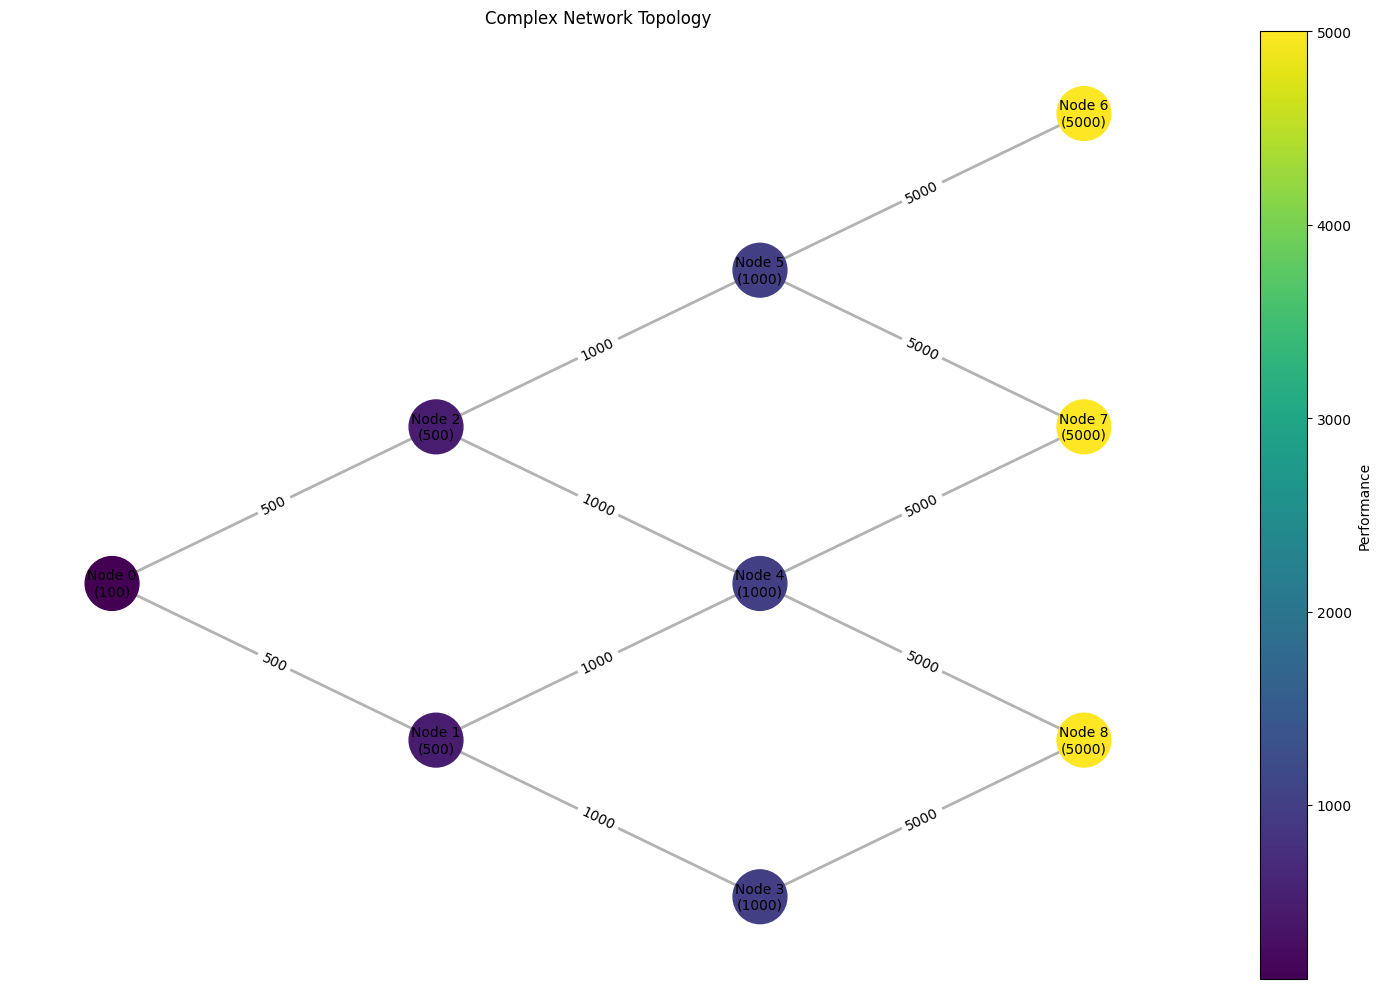


Network Properties:
Network type: Complex
Number of nodes: 9
Number of edges: 11

Nodes:
Node 0 - Performance: 100
Node 1 - Performance: 500
Node 2 - Performance: 500
Node 3 - Performance: 1000
Node 4 - Performance: 1000
Node 5 - Performance: 1000
Node 6 - Performance: 5000
Node 7 - Performance: 5000
Node 8 - Performance: 5000

Edge bandwidths:
Edge 0-2: 500
Edge 0-1: 500
Edge 1-4: 1000
Edge 1-3: 1000
Edge 2-4: 1000
Edge 2-5: 1000
Edge 3-8: 5000
Edge 4-7: 5000
Edge 4-8: 5000
Edge 5-6: 5000
Edge 5-7: 5000


In [2]:
# Создание сложной сети (первый пример)
net = NetGraph(graph_type=1)
net.visualize()
net.print_info()

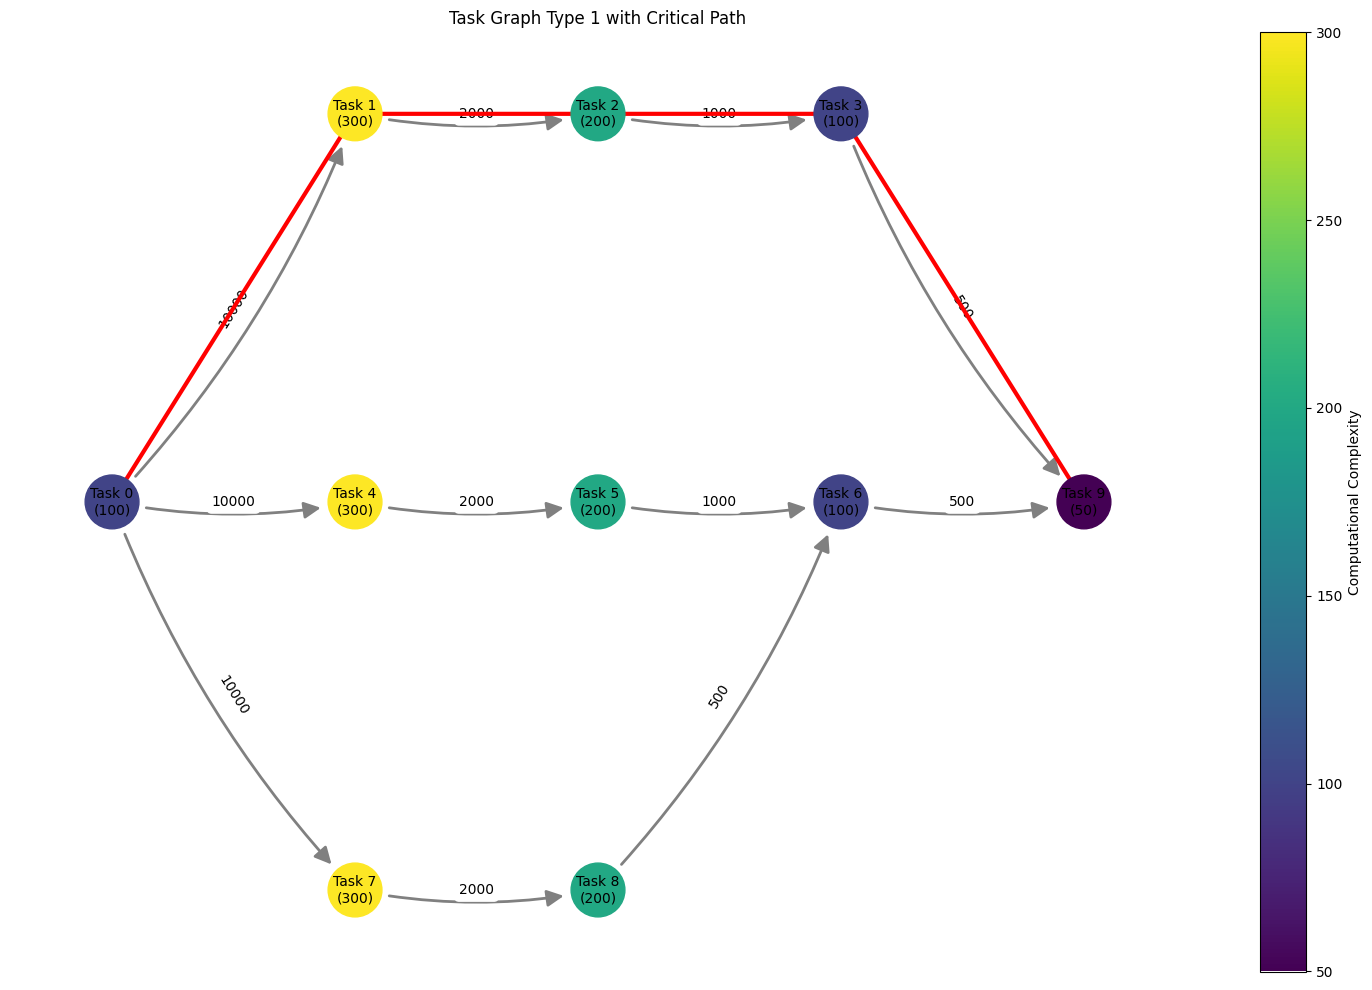


Task Graph Type 1 Properties:
Number of tasks: 10
Number of dependencies: 11
Total computational complexity: 1850
Total data transfer: 39500

Critical Path Information:
Path: 0 -> 1 -> 2 -> 3 -> 9
Length: 14250


In [3]:
task = TaskGraph(graph_type=1)
task.visualize()
task.print_info()

In [4]:
import numpy as np
from typing import Tuple, Dict, List


def calculate_H(vector, problem):
    """
    Обновляет матрицу H для учета узлов, участвующих в транзите данных.

    Args:
        H: ndarray, изначальная матрица назначения задач, где H[i, j] = 1, если задача j назначена на узел i.
        task_scheduler: TaskScheduler, объект класса TaskScheduler с данными о расписании и передачах данных.

    Returns:
        ndarray: матрица H с учетом транзита данных.
    """
    num_nodes = len(problem.scheduler.net_graph.nodes)
    num_tasks = len(problem.scheduler.task_graph.operations)
    
    # Формируем матрицу назначений H
    H = np.zeros((num_nodes, num_tasks))
    
    # Заполняем матрицу H для вычислительных задач
    for task_id, node_id in enumerate(vector):
        H[node_id][task_id] = 1

    # Идем по каждому пути передачи данных
    for transfer_path in problem.scheduler.data_transfers:
        # Обрабатываем все узлы в пути, кроме последнего (последний - получатель данных)
        for node in transfer_path:
            # Узел участвует в транзите, учитываем это в матрице H
            for task in range(num_tasks):  # Отмечаем узел для всех задач в транзите
                H[node, task] = 1

    return H

In [ ]:
import math
import numpy as np
import networkx as nx

def calculate_resource_cost(vector, problem):
    """
    Расчет стоимости привлекаемых ресурсов для решения задачи с учетом энергопотребления,
    назначений задач и нормализации критериев.

    Args:
        vector: list, распределение задач по узлам.
        problem: объект класса, представляющий вычислительную платформу.

    Returns:
        dict: результаты по стоимости ресурсов, нормализованным значениям и связанным метрикам.
    """
    # Шаг 1: Генерация расписания и матрицы H
    problem.scheduler.calculate_schedule(vector)  # Составляем расписание
    H = problem.scheduler.calculate_H(vector)    # Генерируем матрицу H

    # Шаг 2: Инициализация данных
    num_nodes = len(problem.scheduler.net_graph.nodes)  # Количество узлов
    num_tasks = len(problem.scheduler.task_graph.operations)  # Количество задач

    # Стоимость применения ресурсов и стоимость операций
    C = [problem.scheduler.net_graph.nodes[i].get_base_cost() for i in range(num_nodes)]  # С = {c1, c2, ..., cm}
    C_operation = [problem.scheduler.net_graph.nodes[i].get_operation_cost() for i in range(num_nodes)]  # Co = {co1, co2, ..., com}

    # h_{ij} и B
    B = [0] * num_nodes  # Узел используется или нет (bi)
    total_C0 = 0  # Общая стоимость привлеченных ресурсов C0
    total_C_operation = 0  # Общая стоимость операций Co

    # Шаг 3: Расчет C0 и Co
    for i in range(num_nodes):
        for j in range(num_tasks):
            if H[i][j] > 0:  # Если задача j назначена на узел i
                B[i] = 1  # Узел считается используемым
                total_C0 += C[i] * B[i]
                total_C_operation += C_operation[i] * problem.scheduler.task_graph.operations[j].get_task_complexity() * H[i][j]

    # Шаг 4: Дополнительное использование узлов для транзита данных
    for src, dst, _, _, task, successor in problem.scheduler.data_transfers:
        B[src] = 1  # Узел источника данных используется
        B[dst] = 1  # Узел приемника данных используется
        total_C0 += C[src] * B[src]
        total_C0 += C[dst] * B[dst]

    # Шаг 5: Нормализация
    C_total = sum(C)  # Суммарная большая стоимость базовой элементной базы
    Co_total = sum(
        sum(problem.scheduler.task_graph.operations[j].get_task_complexity() * C_operation[i] * H[i][j] for j in range(num_tasks))
        for i in range(num_nodes)
    )  # Полная стоимость операций

    # Нормализованные критерии
    C0_norm = total_C0 / C_total if C_total > 0 else 0  # Нормализованная базовая стоимость
    C_operation_norm = total_C_operation / Co_total if Co_total > 0 else 0  # Нормализованная стоимость операций

    # Формирование результата
    result = {
        "C0": total_C0,         # Общая стоимость привлеченных ресурсов
        "C0_norm": C0_norm,     # Нормализованная стоимость привлеченных ресурсов
        "total_C_operation": total_C_operation,         # Общая стоимость совершаемых операций
        "C_operation_norm": C_operation_norm,     # Нормализованная стоимость операций
        "B": B                  # Использование узлов
    }

    return result


def calculate_energy_consumption(vector: list, problem) -> dict:
    """
    Рассчитывает энергозатраты на решение задачи
    
    Args:
    vector: list, Распределение задач по узлам
    problem: Problem, Объект, содержащий информацию о задаче и планировщике
        
    Returns: dict, Словарь с результатами расчетов энергозатрат
    """
    
    problem.scheduler.calculate_schedule(vector)
    H = problem.scheduler.calculate_H(vector)
    
    results = {
        'node_energy': {},
        'total_energy': 0,
        'normalized_energy': {},
        'total_normalized_energy': 0
    }
    
    task_graph = problem.task_graph.graph  # Получаем граф задач
    tasks = problem.task_graph.tasks       # Получаем словарь задач
    
    # Расчет энергозатрат для каждого узла
    for node in problem.net_graph.nodes:
        node_id = node.id
        E_comp = 0
        E_receive = 0
        E_send = 0
        
        # Энергозатраты на вычисления через матрицу H
        for task_id in range(len(tasks)):
            if H[node_id][task_id] == 1:
                task = tasks[task_id]
                E_comp += task.complexity * node.e_comp
                
                # Энергозатраты на прием входных данных
                E_receive += task.input_data * node.e_receive
                
                # Энергозатраты на отправку выходных данных
                E_send += task.output_data * node.e_send
        
        E_total = E_receive + E_comp + E_send
        
        results['node_energy'][node_id] = {
            'receive': E_receive,
            'compute': E_comp,
            'send': E_send,
            'total': E_total
        }
    
    # Расчет максимальных энергозатрат с учетом диаметра сети
    network_diameter = nx.diameter(problem.net_graph.graph)
    
    # Суммарная сложность всех задач
    total_task_complexity = sum(task.complexity for task in tasks.values())
    
    # Суммарный объем передаваемых данных из графа задач
    total_data_volume = sum(
        data['data_volume']
        for _, _, data in task_graph.edges(data=True)
    )
    
    # Максимальные значения энергозатрат среди всех узлов
    max_compute_energy = max(node.e_comp for node in problem.net_graph.nodes)
    max_receive_energy = max(node.e_receive for node in problem.net_graph.nodes)
    max_send_energy = max(node.e_send for node in problem.net_graph.nodes)
    
    # Расчет максимальных возможных энергозатрат
    E_max = (
        # Максимальные затраты на вычисления
        total_task_complexity * max_compute_energy +
        # Максимальные затраты на передачу с учетом диаметра сети
        total_data_volume * network_diameter * (max_receive_energy + max_send_energy)
    )
    
    # Расчет общих энергозатрат
    results['total_energy'] = sum(
        node['total'] 
        for node in results['node_energy'].values()
    )
    
    # Нормализация энергозатрат для каждого узла
    for node_id in results['node_energy']:
        node_total = results['node_energy'][node_id]['total']
        results['normalized_energy'][node_id] = node_total / E_max if E_max > 0 else 0
    
    # Нормализация общих энергозатрат
    results['total_normalized_energy'] = results['total_energy'] / E_max if E_max > 0 else 0
    
    return results


def calculate_reliability_and_load_balancing(vector, problem, tau, k):
    """
    Расчет надежности системы и выравнивания вычислительной нагрузки.

    Args:
        vector: list, распределение задач по узлам.
        problem: объект класса, представляющий вычислительную платформу.
        tau: float, временной интервал для расчета вероятности безотказной работы.
        k: float, коэффициент, связывающий загруженность и температуру вычислителя.

    Returns:
        dict: результаты по надежности системы (P0) и критерию выравнивания нагрузки (Δ).
    """
    # Шаг 1: Генерация расписания и матрицы H
    problem.scheduler.calculate_schedule(vector)  # Составляем расписание
    H = problem.scheduler.calculate_H(vector)    # Генерируем матрицу H
    analysis = problem.scheduler.get_complete_analysis(vector)  # Получаем полный анализ

    # Шаг 2: Инициализация данных
    num_nodes = len(problem.scheduler.net_graph.nodes)  # Количество узлов
    num_tasks = len(problem.scheduler.task_graph.operations)  # Количество задач

    # Параметры узлов: интенсивность отказов λ0i, производительность (p_i), загрузка канала u_ij
    lambda_0 = [problem.scheduler.net_graph.nodes[i].get_failure_rate() for i in range(num_nodes)]  # λ0i
    performance = [problem.scheduler.net_graph.nodes[i].get_performance() for i in range(num_nodes)]  # p_i
    channel_load = [[problem.scheduler.net_graph.nodes[i].get_channel_load(j) for j in range(num_tasks)] for i in range(num_nodes)]  # u_ij

    # Шаг 3: Расчет полной загруженности узла и последовательной загрузки задач
    T0 = analysis["statistics"]["total_time"]  # Ограничение на время решения задачи T0
    node_loads = []  # D_i - Загруженность узлов
    for i in range(num_nodes):
        Ti_b = sum(
            H[i][j] * problem.scheduler.task_graph.operations[j].get_task_complexity() / (performance[i] * channel_load[i][j])
            for j in range(num_tasks)
        )  # T_i^b = Σ h_{ij} * w_j / (p_i * u_{ij})
        Di = Ti_b / T0  # D_i = T_i^b / T0
        node_loads.append(Di)

    # Шаг 4: Расчет вероятности безотказной работы ВБР P0
    P0_product = 1
    for i in range(num_nodes):
        Di = node_loads[i]
        exponent = -lambda_0[i] * tau * 2 ** (k * Di / 10)
        P0_product *= math.exp(exponent)
    P0 = P0_product  # P0 = Π e^(-λ0i τ 2^(kDi/10))

    # Шаг 5: Расчет критерия выравнивания вычислительной нагрузки Δ Коэффициент вариации в процентах
    load_balancing = 1  # Инициализация критерия Δ
    mean = np.mean(node_loads)
    std = np.std(node_loads)

    if mean == 0 or std == 0:
        load_balancing = 0
    else:
        load_balancing = (std / mean)

    # Формирование результата
    result = {
        "P_0": P0,                     # Надежность системы
        "D": node_loads,     # Загруженность узлов
        "Δ": load_balancing  # Критерий выравнивания нагрузки
    }

    return result


def calculate_network_load(vector, problem):
    """
    Расчет нагрузки на сетевую инфраструктуру.

    Args:
        vector: list, распределение задач по узлам.
        problem: объект класса, представляющий вычислительную платформу.

    Returns:
        dict: результаты по нагрузке на сеть, включая нормализованный объем данных, матрицы H и V.
    """
    # Шаг 1: Генерация расписания и матрицы H
    problem.scheduler.calculate_schedule(vector)  # Составляем расписание
    H = problem.scheduler.calculate_H(vector)    # Генерируем матрицу H
    data_transfers = problem.scheduler.data_transfers  # Получаем данные о передаче из расписания

    # Инициализация параметров
    num_nodes = len(problem.scheduler.net_graph.nodes)  # Количество узлов (M)
    num_tasks = len(problem.scheduler.task_graph.operations)  # Количество задач (N)

    # Матрица V: объем данных, передаваемых между задачами
    V = problem.scheduler.get_data_transfer_matrix()  # Матрица передачи данных v_{jz}

    # Шаг 2: Рассчет объемов данных для задач
    v_j0 = [sum(V[j]) for j in range(num_tasks)]  # v_j^0 = Σ v_{jz} — объем данных, исходящих из задачи j

    # Шаг 3: Вычисление исходящего объема данных на узел
    V_i = [0] * num_nodes  # Объем исходящих данных (на каждую задачу)
    for i in range(num_nodes):  # Для каждого узла
        for j in range(num_tasks):  # Для каждой задачи
            if H[i][j] == 1:  # Если задача j закреплена за узлом i
                V_i[i] += sum(V[j][z] for z in range(num_tasks) if H[i][z] == 0)  # Учитываем только данные, выходящие через сеть

    # Шаг 4: Суммарная нагрузка на сеть
    V_0 = sum(V_i)  # Общий объем данных, переданных через сеть: V_0 = Σ_i V_{i}

    # Шаг 5: Максимально возможный объем данных
    V_max = sum(
        sum(V[j][z] for z in range(num_tasks)) for j in range(num_tasks)
    )  # Максимальный объем, если каждая задача размещена на своем узле

    # Шаг 6: Определение нормализованных значений
    V_0_norm = V_0 / V_max if V_max > 0 else 0  # Нормализация для общего объема данных

    # Шаг 7: Максимальный объем для одной строки
    V_max_1 = max(sum(V[j]) for j in range(num_tasks))  # Максимальная сумма строки V
    V_i_norm = [V_i[i] / V_max_1 if V_max_1 > 0 else 0 for i in range(num_nodes)]  # Нормализация нагрузки на узлы

    # Формирование результата
    result = {
        'V_i': V_i.tolist(),             # Объем исходящих данных по узлам
        'V_i_norm': V_i_norm.tolist(),   # Нормализованный объем по узлам
        'V_0': V_0,                      # Общий объем передаваемых данных
        'V_0_norm': V_0_norm,            # Нормализованный общий объем
        'V_max': V_max,                  # Максимально возможный объем
        'V_max_1': V_max_1,              # Максимальный объем для одной задачи
        'data_transfers': data_transfers, # Детали передач данных из расписания
        'V': V.tolist(),                 # Матрица передачи данных
        'H': H.tolist()                  # Матрица назначений
    }

    return result


def calculate_resource_costs(vector, problem):
    return calculate_resource_cost(vector, problem)['C0_norm']

In [6]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[calculate_resource_costs], t_lim=10, net_speed=5000, bounds={0: [0,0]}, name="NETproblem_1")

In [7]:
solution = problem.generate_random_solution()
solution

array([0, 7, 3, 3, 0, 7, 8, 2, 5, 4])

In [ ]:
123у123123

In [12]:
problem.scheduler.calculate_schedule(solution)

In [13]:
problem.scheduler.data_transfers

[(np.int64(0), 2, 101.0, 121.0, 0, 1),
 (2, 4, 161.0, 171.0, 0, 1),
 (4, np.int64(7), 191.0, 193.0, 0, 1),
 (np.int64(0), 2, 221.0, 241.0, 0, 7),
 (np.int64(7), 4, 195.46, 195.86, 1, 2),
 (4, 1, 199.86, 201.86, 1, 2),
 (1, np.int64(3), 209.86, 211.86, 1, 2),
 (np.int64(0), 2, 264.0, 268.0, 4, 5),
 (2, 4, 276.0, 278.0, 4, 5),
 (4, np.int64(7), 282.0, 282.4, 4, 5),
 (np.int64(2), 5, 282.6, 284.6, 7, 8),
 (np.int64(7), 4, 283.03999999999996, 283.23999999999995, 5, 6),
 (4, np.int64(8), 285.23999999999995, 285.43999999999994, 5, 6),
 (np.int64(5), 2, 287.3, 287.8, 8, 6),
 (2, 4, 289.8, 290.3, 8, 6),
 (4, np.int64(8), 291.3, 291.40000000000003, 8, 6),
 (np.int64(3), 1, 214.66, 215.16, 3, 9),
 (1, np.int64(4), 291.40000000000003, 291.90000000000003, 3, 9),
 (np.int64(8), 4, 292.40000000000003, 292.50000000000006, 6, 9)]

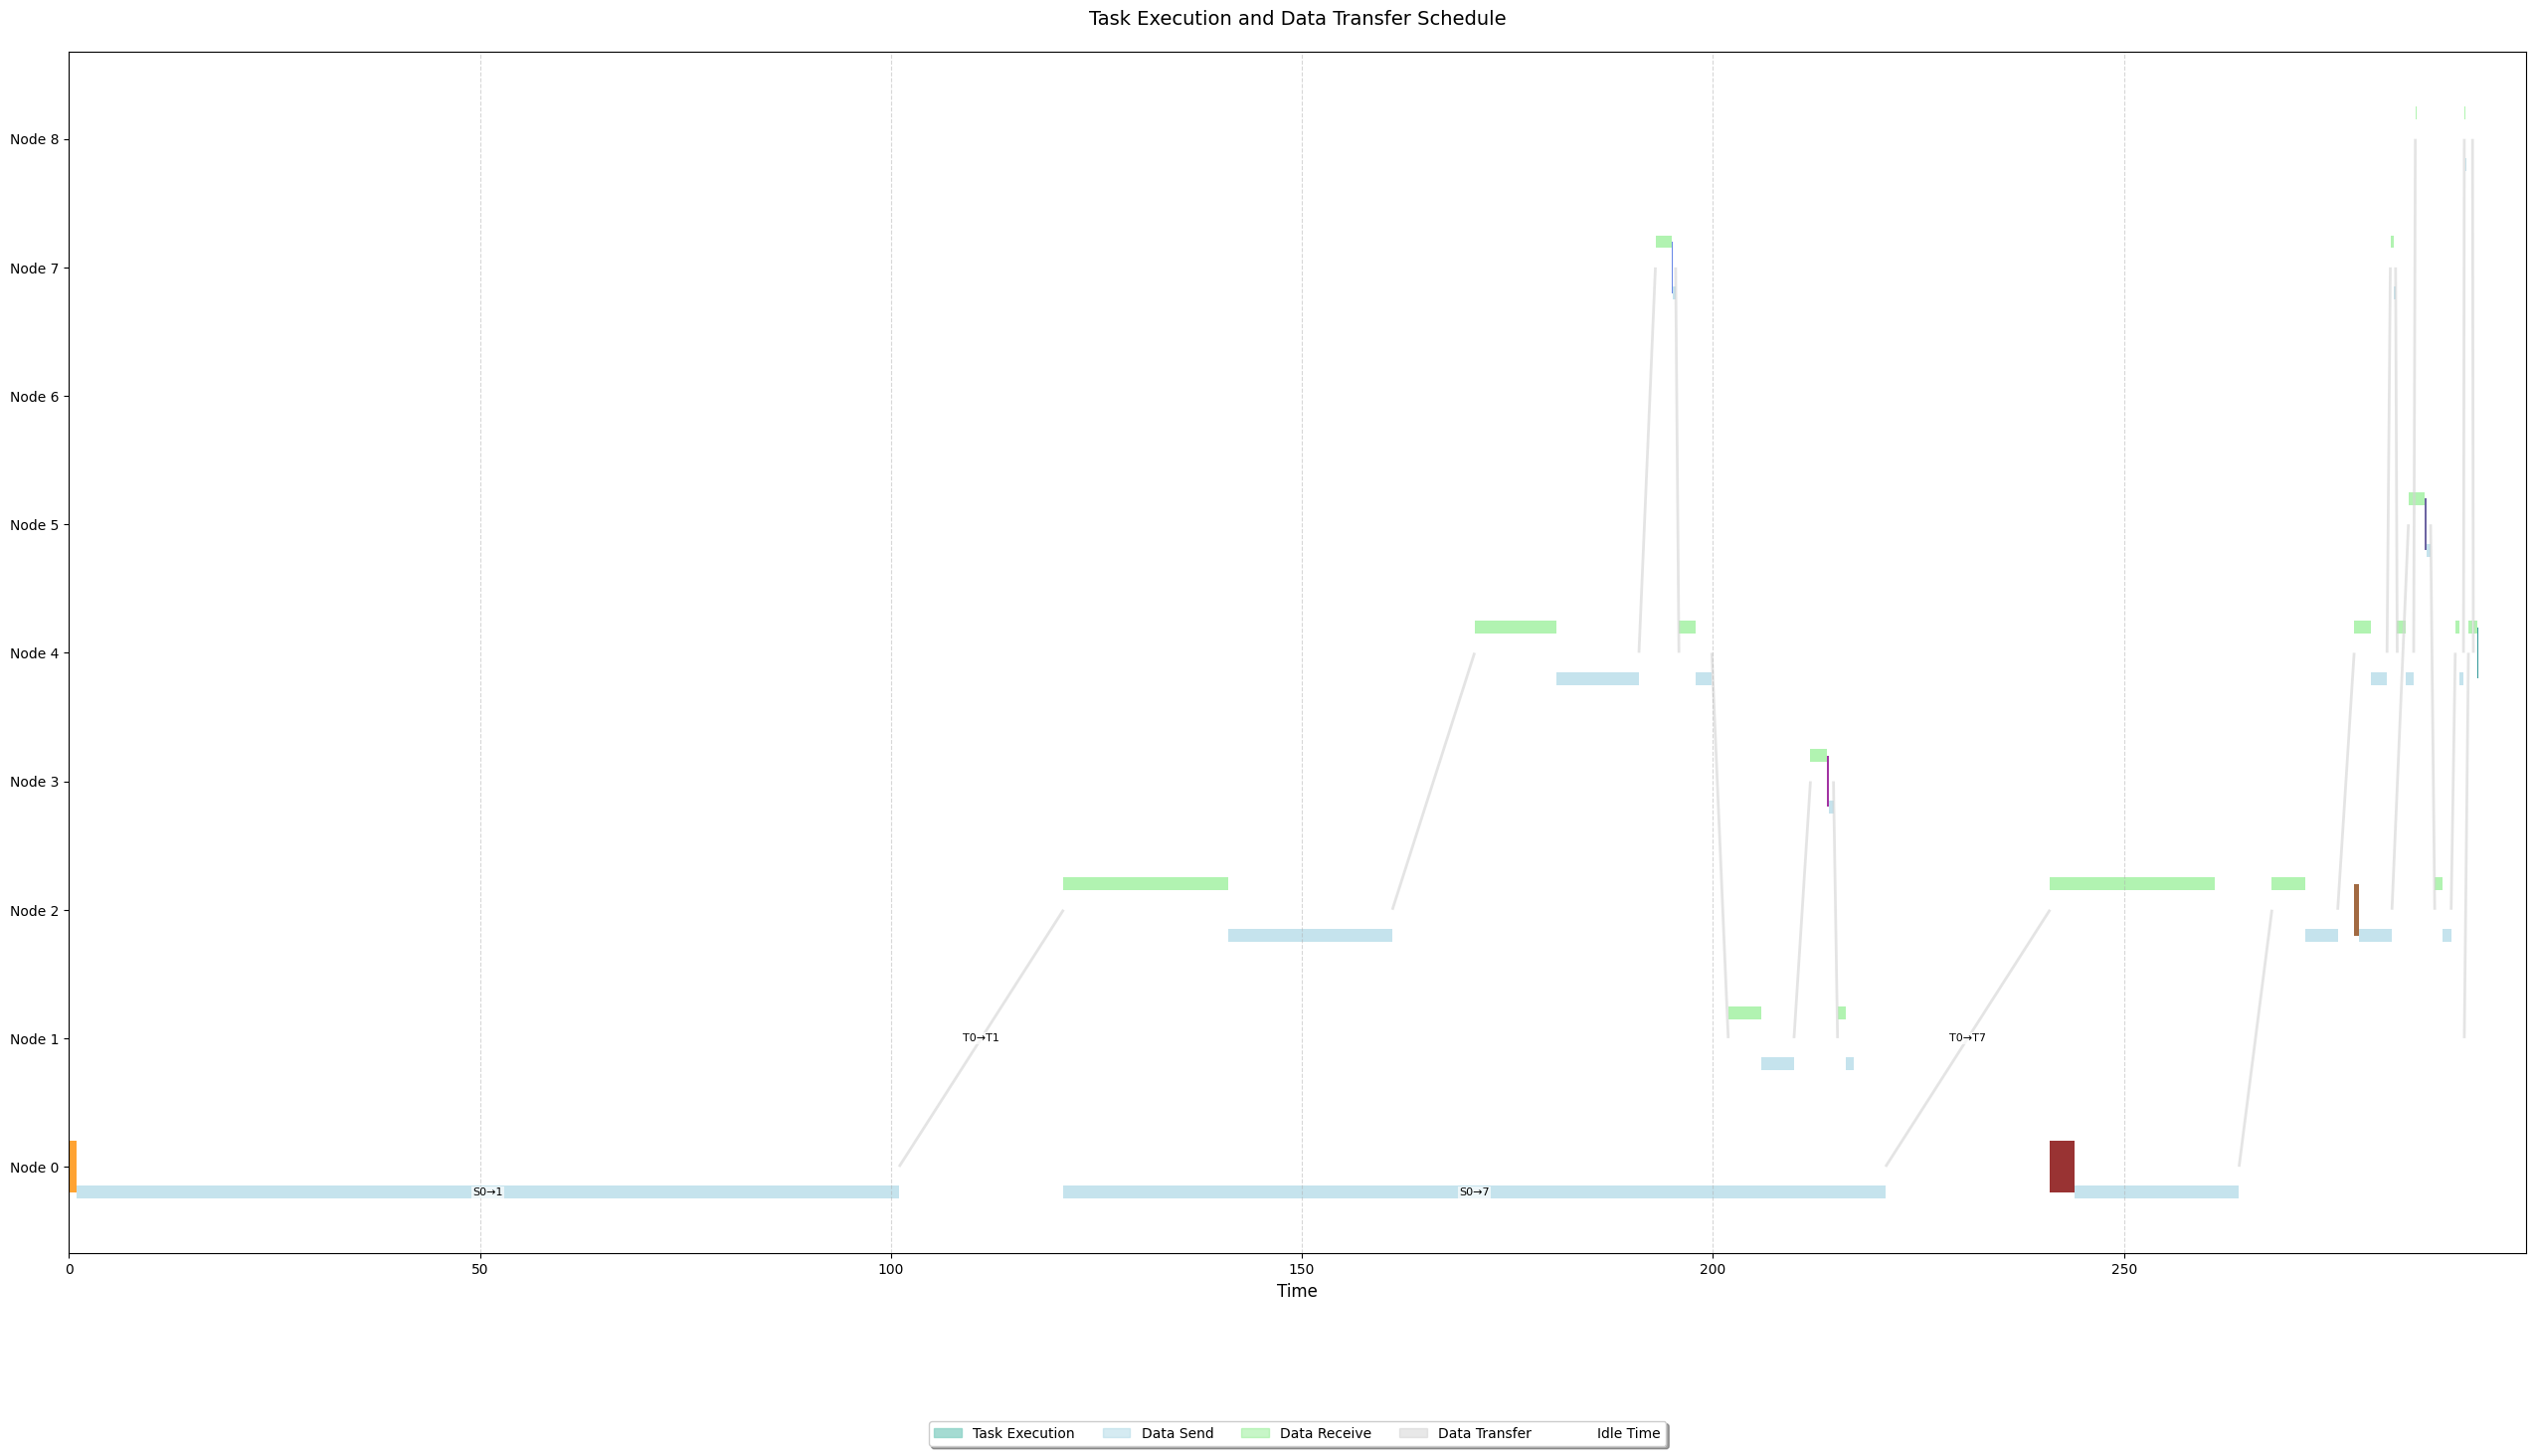

In [14]:
problem.scheduler.calculate_schedule(solution)
problem.scheduler.create_gantt_chart()

In [10]:
def calculate_energy_optimized(vector, problem):
    """
    Оптимизированный расчет энергозатрат и временных характеристик системы 
    с использованием сохраненных данных из schedule и analysis.

    Args:
        vector: list, распределение задач по узлам.
        problem: объект класса, представляющий вычислительную платформу.

    Returns:
        dict: результаты по энергозатратам и временным характеристикам.
    """
    # Шаг 1: Генерируем расписание (если еще не сгенерировано)
    problem.scheduler.calculate_schedule(vector)

    # Шаг 2: Получаем полный анализ (если еще не получено)
    analysis = problem.scheduler.get_complete_analysis(vector)

    # Инициализация энергозатрат
    num_nodes = len(problem.scheduler.net_graph.nodes)  # Количество узлов
    E_receive = [0.0] * num_nodes  # Энергозатраты на прием данных
    E_comp = [0.0] * num_nodes     # Энергозатраты на вычисления
    E_send = [0.0] * num_nodes     # Энергозатраты на отправку данных

    # Шаг 3: Распределяем энергозатраты
    for node_id, node_data in analysis['nodes'].items():
        # Извлечение данных для узла: энергозатраты
        data_received = node_data['data_received']
        compute_load = node_data['compute_load']
        data_sent = node_data['data_sent']

        # Сохраняем энергозатраты
        E_receive[node_id] = data_received * problem.scheduler.net_graph.nodes[node_id].get_energy_receive_cost()
        E_comp[node_id] = compute_load * problem.scheduler.net_graph.nodes[node_id].get_energy_compute_cost()
        E_send[node_id] = data_sent * problem.scheduler.net_graph.nodes[node_id].get_energy_send_cost()
    
    # Шаг 4: Учет энергозатрат на передачу данных между узлами
    for src, dst, start, end, task, successor in problem.scheduler.data_transfers:
        data_volume = problem.scheduler.task_graph.graph[task][successor]['data_volume']
        send_energy = data_volume * problem.scheduler.net_graph.nodes[src].get_energy_send_cost()
        receive_energy = data_volume * problem.scheduler.net_graph.nodes[dst].get_energy_receive_cost()
        E_send[src] += send_energy
        E_receive[dst] += receive_energy

    # Шаг 5: Полные и нормализованные энергозатраты для каждого узла
    E_nodes = [E_receive[i] + E_comp[i] + E_send[i] for i in range(num_nodes)]
    E_total = sum(E_nodes)

    # Максимально возможные энергозатраты (E_full) для нормализации
    E_full = [
        sum(task['complexity'] * problem.scheduler.net_graph.nodes[i].get_energy_compute_cost()
            for task in analysis['tasks'].values()) +
        sum(task['complexity'] * problem.scheduler.net_graph.nodes[i].get_energy_receive_cost()
            for task in analysis['tasks'].values()) +
        sum(task['complexity'] * problem.scheduler.net_graph.nodes[i].get_energy_send_cost()
            for task in analysis['tasks'].values())
        for i in range(num_nodes)
    ]

    E_nodes_norm = [E_nodes[i] / E_full[i] if E_full[i] > 0 else 0 for i in range(num_nodes)]
    E_max = sum(E_full)
    E_norm = E_total / E_max if E_max > 0 else 0

    # Шаг 6: Временные характеристики
    total_time = analysis['statistics']['total_time']  # Время выполнения всей системы

    # Формирование результата
    result = {
        "E_receive": E_receive,        # Энергозатраты на прием
        "E_comp": E_comp,              # Энергозатраты на вычисления
        "E_send": E_send,              # Энергозатраты на отправку
        "E_nodes": E_nodes,            # Полные энергозатраты узлов
        "E_nodes_norm": E_nodes_norm,  # Нормализованные энергозатраты узлов
        "E_total": E_total,            # Полные энергозатраты системы
        "E_norm": E_norm,              # Нормализованные энергозатраты системы
        "total_time": total_time       # Общее время выполнения
    }

    return result


In [11]:
calculate_energy_optimized(solution, problem)

AttributeError: 'NetworkNode' object has no attribute 'get_energy_receive_cost'

In [ ]:

problem.convolution_evaluate_objectives(solution)

{0: NetworkNode(id=0, performance=100, e_receive=0.13871205684224536, e_comp=0.39992964625887034, e_send=0.20746440862321727, cost=108.03655351657333, failure_rate=0.0), 1: NetworkNode(id=1, performance=500, e_receive=0.4834643477405961, e_comp=0.5368168993454108, e_send=0.17465125742590087, cost=527.2235621086286, failure_rate=0.0), 2: NetworkNode(id=2, performance=500, e_receive=0.1308284288053282, e_comp=0.2922834738777292, e_send=0.47271405614832274, cost=566.1365489766227, failure_rate=0.0), 3: NetworkNode(id=3, performance=1000, e_receive=0.1624884580496081, e_comp=0.7766834298715737, e_send=0.4611417332551868, cost=1057.7865642062327, failure_rate=0.0), 4: NetworkNode(id=4, performance=1000, e_receive=0.3929789900474393, e_comp=0.3933357318394409, e_send=0.3281622962570693, cost=901.2354205715659, failure_rate=0.0), 5: NetworkNode(id=5, performance=1000, e_receive=0.39926087842968283, e_comp=0.45338754051219554, e_send=0.13988118582857503, cost=820.7793498516816, failure_rate=0.

{'C0': np.float64(8436.354987558665),
 'C0_norm': np.float64(0.408048953869659),
 'Co_i': [39.99296462588703,
  161.04506980362322,
  87.68504216331876,
  0.0,
  137.66750614380433,
  90.6775081024391,
  0.0,
  320.0432688522092,
  0.0],
 'Co_i_norm': [0.05405405405405405,
  0.16216216216216217,
  0.16216216216216214,
  0.0,
  0.18918918918918917,
  0.10810810810810811,
  0.0,
  0.3243243243243244,
  0.0],
 'Co': np.float64(837.1113596912817),
 'Co_norm': np.float64(0.09981192068545047),
 'used_nodes': [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
 'H': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [0.0, 

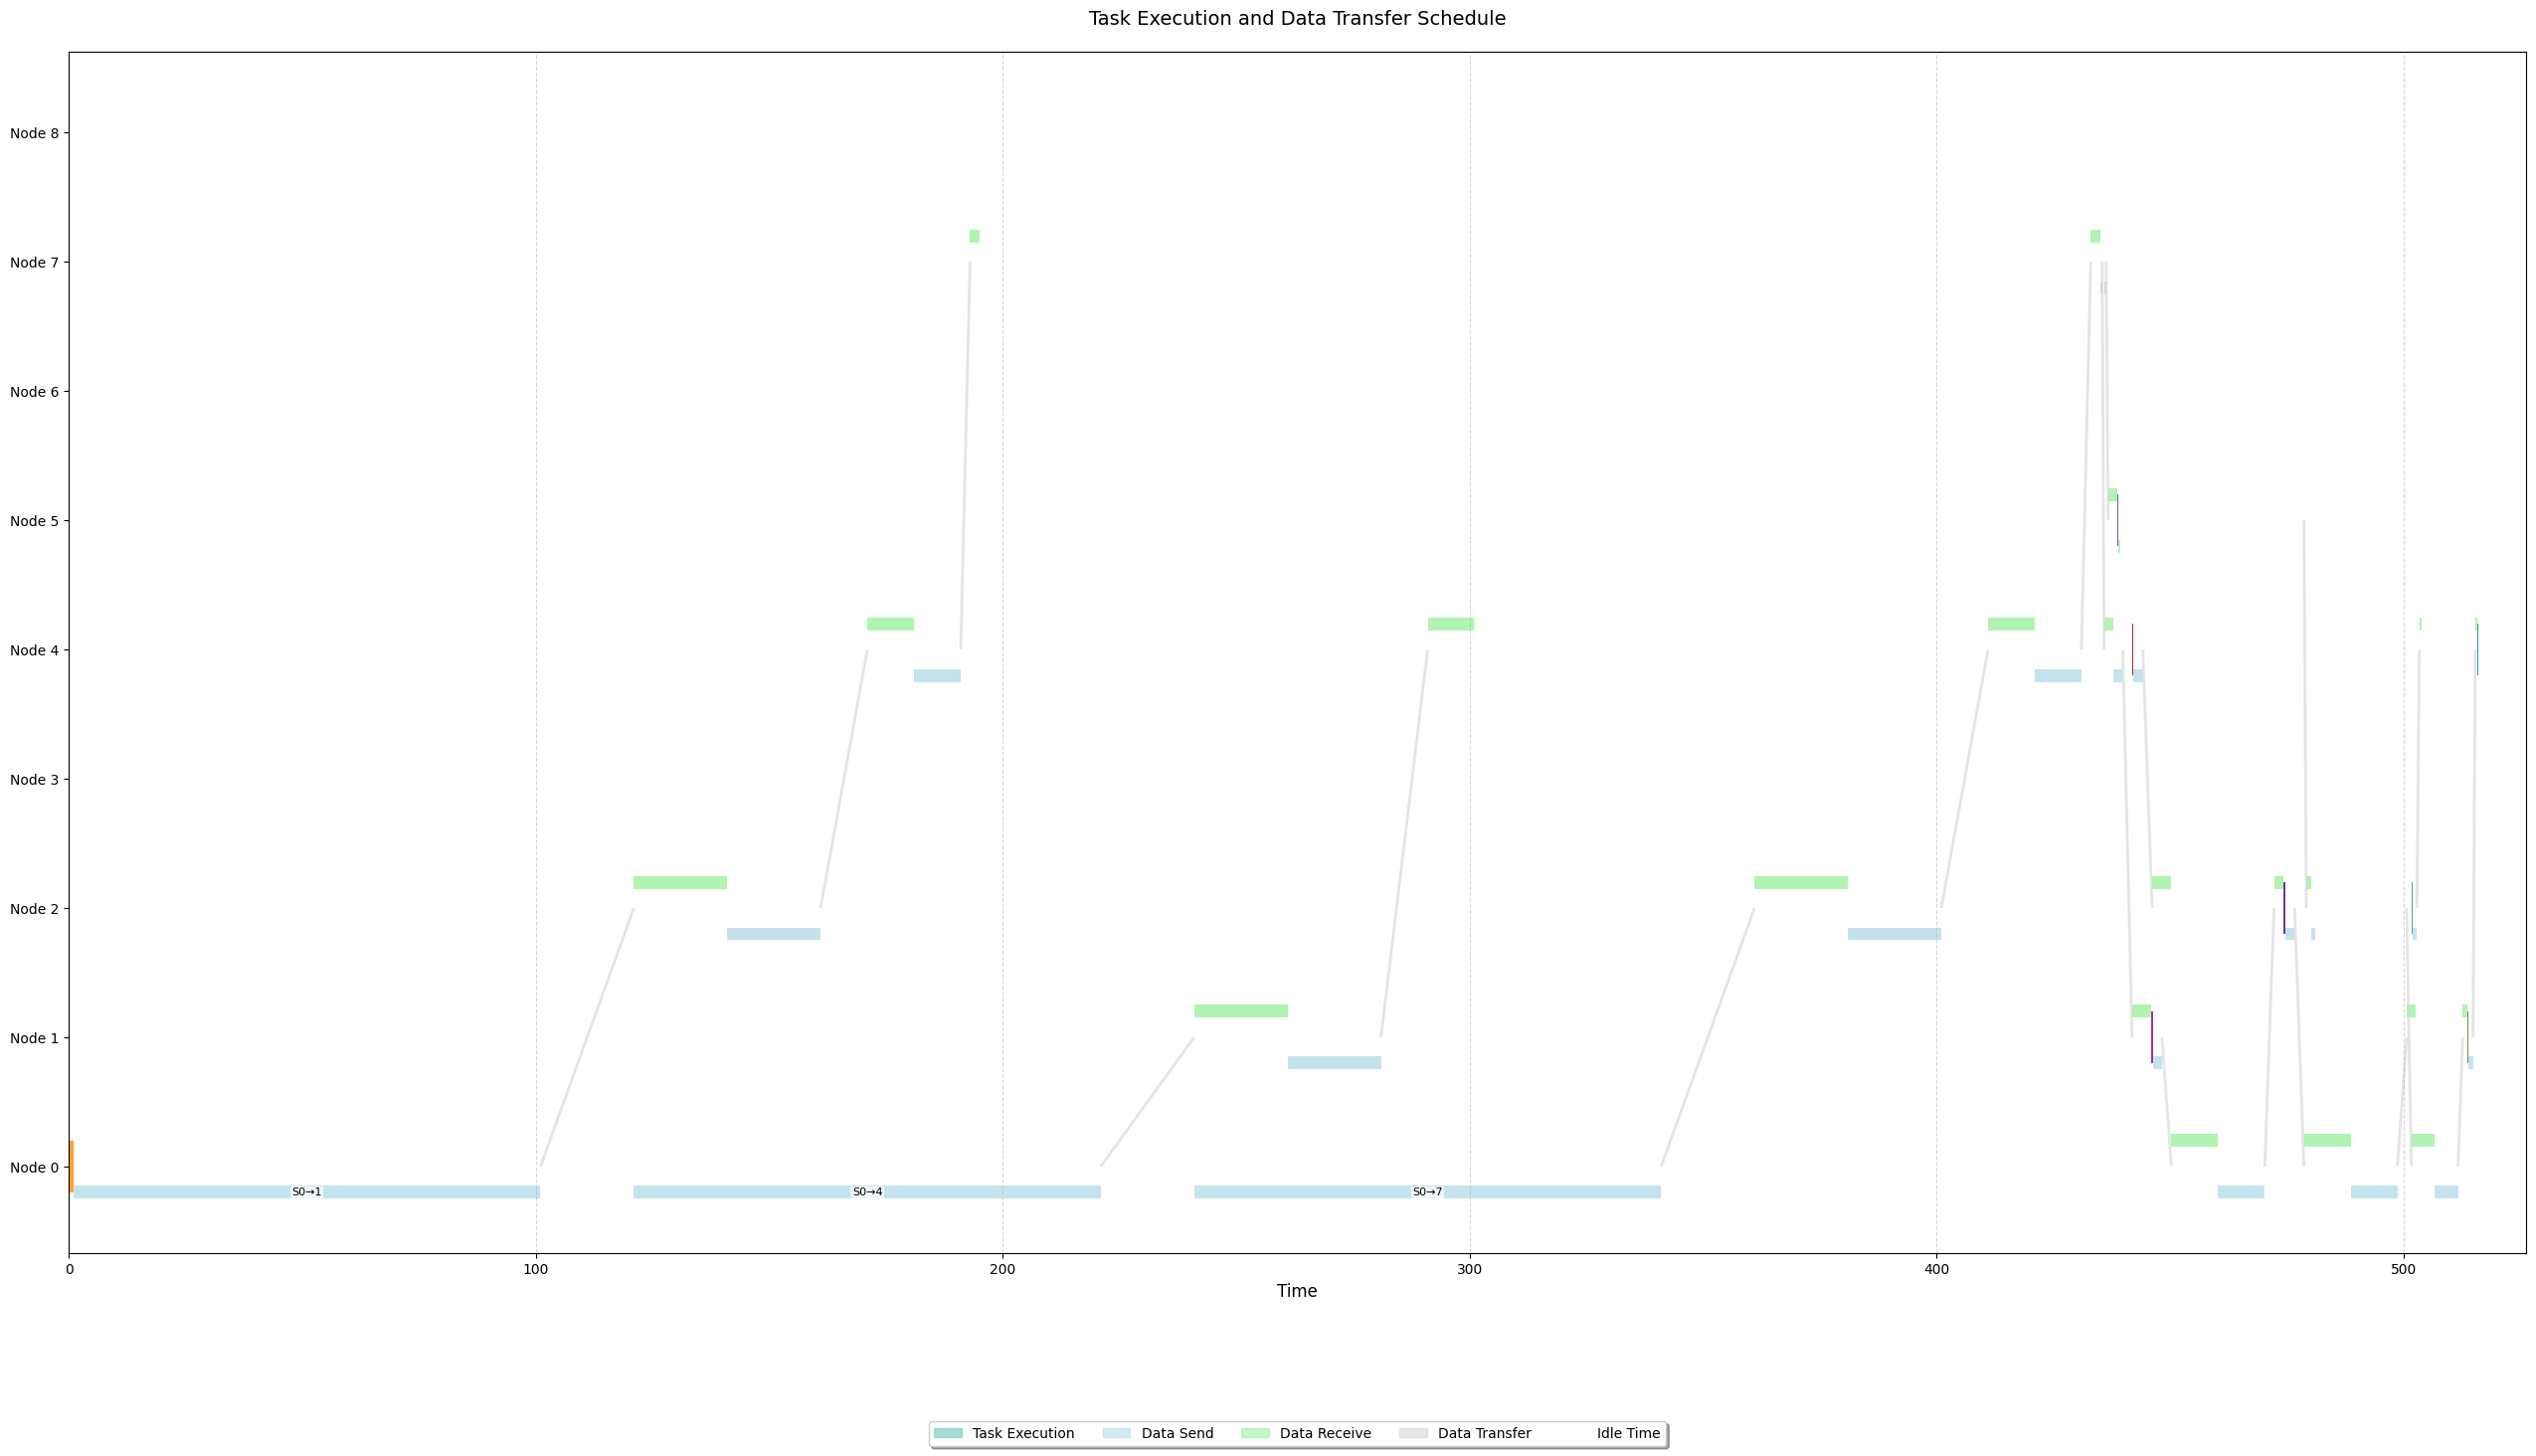

In [ ]:
problem.scheduler.calculate_schedule(solution)
problem.scheduler.create_gantt_chart()

In [ ]:
problem.scheduler.print_complete_analysis()

TypeError: TaskScheduler.get_complete_analysis() missing 1 required positional argument: 'distribution'